<div style="text-align: left; background-color:black; font-family: Trebuchet MS; color:#70e000; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 58px;border-style: solid;border-color: black solid;"> Credit Card Fraud Transaction Classification </div>

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2

for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
train_data = pd.read_csv('fraudTrain.csv', index_col=0)
test_data = pd.read_csv('fraudTest.csv', index_col=0)

**EDA**: Understand dataset   
**Feature Engineering**: Adding features to improve model training

In [3]:
print(train_data.head())

  trans_date_trans_time            cc_num                            merchant   
0   2019-01-01 00:00:18  2703186189652095          fraud_Rippin, Kub and Mann  \
1   2019-01-01 00:00:44      630423337322     fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661                fraud_Lind-Buckridge   
3   2019-01-01 00:01:16  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4   2019-01-01 00:03:06   375534208663984                 fraud_Keeling-Crist   

        category     amt      first     last gender   
0       misc_net    4.97   Jennifer    Banks      F  \
1    grocery_pos  107.23  Stephanie     Gill      F   
2  entertainment  220.11     Edward  Sanchez      M   
3  gas_transport   45.00     Jeremy    White      M   
4       misc_pos   41.96      Tyler   Garcia      M   

                         street            city  ...      lat      long   
0                561 Perry Cove  Moravian Falls  ...  36.0788  -81.1781  \
1  43039 Riley Greens Suite 393 

In [4]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop               

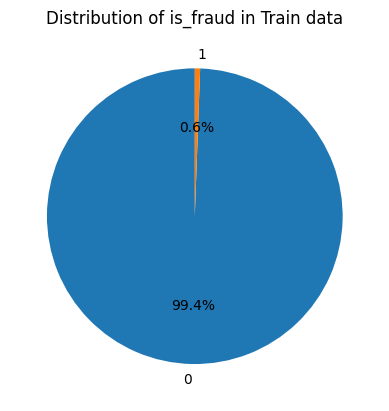

is_fraud
0    1289169
1       7506
Name: count, dtype: int64


In [5]:
value_counts = train_data['is_fraud'].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of is_fraud in Train data')
plt.show()
print(value_counts)

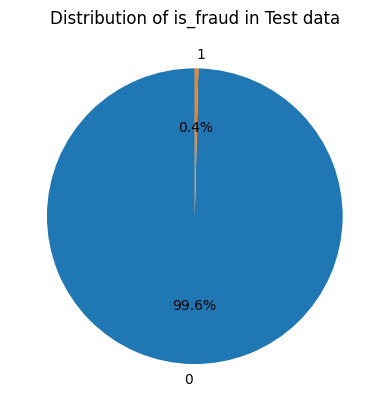

is_fraud
0    553574
1      2145
Name: count, dtype: int64


In [6]:
value_counts = test_data['is_fraud'].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of is_fraud in Test data')
plt.show()
print(value_counts)

Comment: Both train and test dataset are similarly imbalanced. As such, cross-validation techniques for partitioning purposes are not required. 

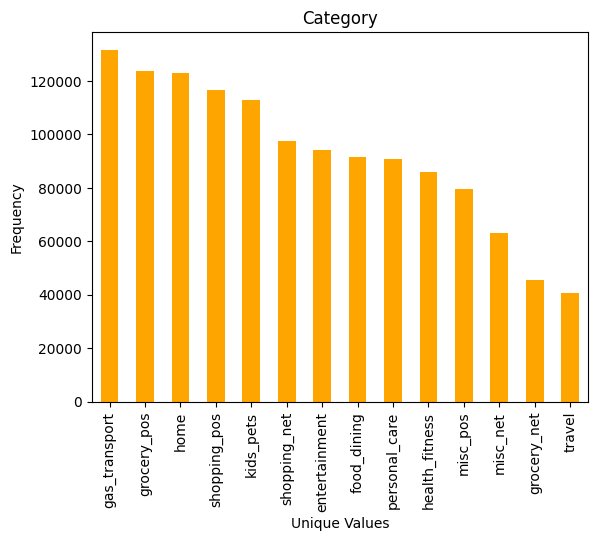

In [7]:
value_counts = train_data['category'].value_counts()
value_counts.plot(kind='bar', color='orange')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Category')
plt.show()

In [8]:
print(train_data['gender'].value_counts())

gender
F    709863
M    586812
Name: count, dtype: int64


Apply One Hot Encoding on _category_ and _gender_ for model training purposes.

In [9]:
train_data = pd.get_dummies(train_data, columns = ['category', 'gender'], prefix = ['category', 'gender'])
test_data = pd.get_dummies(test_data, columns = ['category', 'gender'], prefix = ['category', 'gender'])

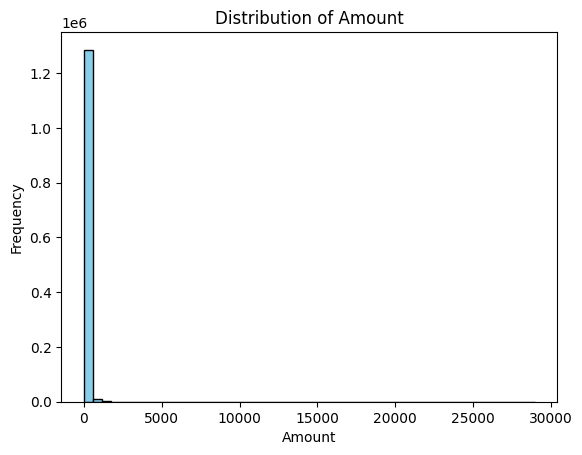

In [10]:
plt.hist(train_data['amt'], bins=50, color='skyblue', edgecolor='black')

plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Amount')
plt.show()

Perform log transformation to reduce the skewness of Amount variable.

In [11]:
train_data['log_amt'] = np.log(train_data['amt'])
test_data['log_amt'] = np.log(test_data['amt'])

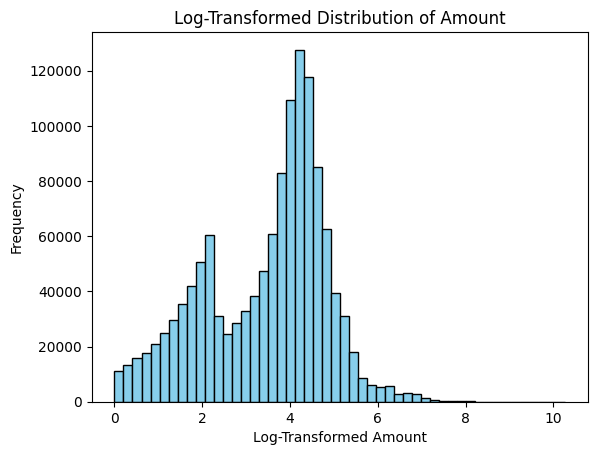

In [12]:
plt.hist(train_data['log_amt'], bins=50, color='skyblue', edgecolor='black')

plt.xlabel('Log-Transformed Amount')
plt.ylabel('Frequency')
plt.title('Log-Transformed Distribution of Amount')
plt.show()

Comment: Bimodal Distribution of Log-Transformed Amount, potentially showing two subgroups of transactions in the dataset.

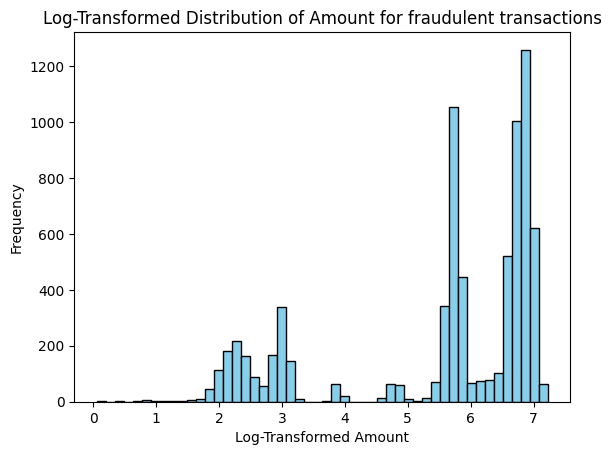

In [13]:
plt.hist(train_data[train_data['is_fraud'] == 1]['log_amt'], bins=50, color='skyblue', edgecolor='black')

plt.xlabel('Log-Transformed Amount')
plt.ylabel('Frequency')
plt.title('Log-Transformed Distribution of Amount for fraudulent transactions')
plt.show()

Comment: Distribution of log_amt for fraudulent transactions similar to the distribution of the entire sample.

Calculate the distance in km, between customer coordinates (lat, long) and merchant coordinates (merch_lat, merch_long) using Haversine formula.   

In [14]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    distance = 2 * R * atan2(sqrt(a), sqrt(1 - a))
    return distance

# Apply Haversine function to create the "Distance" column
train_data['distanceInKM'] = train_data.apply(lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)
test_data['distanceInKM'] = test_data.apply(lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)


In [15]:
# Verify
print(train_data[['lat','long','merch_lat','merch_long','distanceInKM']].head())

       lat      long  merch_lat  merch_long  distanceInKM
0  36.0788  -81.1781  36.011293  -82.048315     78.597568
1  48.8878 -118.2105  49.159047 -118.186462     30.212176
2  42.1808 -112.2620  43.150704 -112.154481    108.206083
3  46.2306 -112.1138  47.034331 -112.561071     95.673231
4  38.4207  -79.4629  38.674999  -78.632459     77.556744


Apply sine and cosine transformations on transaction date and time to capture cyclical patterns of the days in a week. 

In [16]:
train_data['trans_datetime'] = pd.to_datetime(train_data['trans_date_trans_time'])
train_data['DayOfWeek'] = train_data['trans_datetime'].dt.dayofweek # 0 to 6

test_data['trans_datetime'] = pd.to_datetime(test_data['trans_date_trans_time'])
test_data['DayOfWeek'] = test_data['trans_datetime'].dt.dayofweek # 0 to 6

In [17]:
# Apply sine and cosine transformations
train_data['DayOfWeekSin'] = np.sin(2 * np.pi * train_data['DayOfWeek'] / 7)
train_data['DayOfWeekCos'] = np.cos(2 * np.pi * train_data['DayOfWeek'] / 7)

test_data['DayOfWeekSin'] = np.sin(2 * np.pi * test_data['DayOfWeek'] / 7)
test_data['DayOfWeekCos'] = np.cos(2 * np.pi * test_data['DayOfWeek'] / 7)


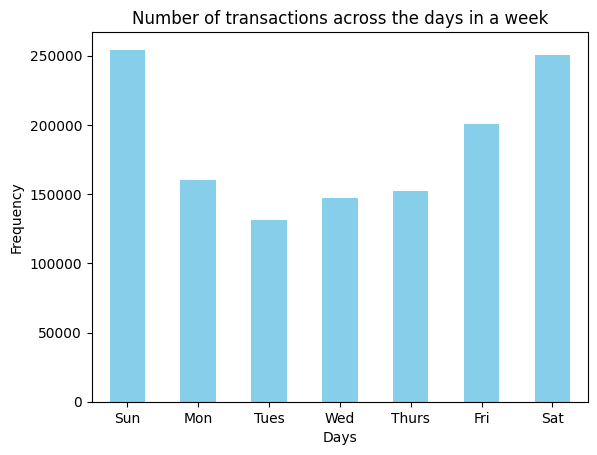

In [18]:
value_counts = train_data['DayOfWeek'].value_counts().sort_index()
value_counts.plot(kind='bar', color='skyblue')
plt.title('Number of transactions across the days in a week')
plt.ylabel('Frequency')
plt.xlabel('Days')

plt.xticks(value_counts.index, ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'], rotation=0)  

plt.show()

Create age of customer based on date of birth (dob)  
Age = Transaction Date - Date of Birth

In [19]:
train_data['dob'] = pd.to_datetime(train_data['dob'])
train_data['age'] = np.ceil((train_data['trans_datetime'] - train_data['dob']).dt.days / 365).astype(int)

test_data['dob'] = pd.to_datetime(test_data['dob'])
test_data['age'] = np.ceil((test_data['trans_datetime'] - test_data['dob']).dt.days / 365).astype(int)

In [20]:
# Verify
print(train_data[['dob', 'trans_datetime', 'age']].head())

         dob      trans_datetime  age
0 1988-03-09 2019-01-01 00:00:18   31
1 1978-06-21 2019-01-01 00:00:44   41
2 1962-01-19 2019-01-01 00:00:51   57
3 1967-01-12 2019-01-01 00:01:16   53
4 1986-03-28 2019-01-01 00:03:06   33


In [21]:
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   trans_date_trans_time    555719 non-null  object        
 1   cc_num                   555719 non-null  int64         
 2   merchant                 555719 non-null  object        
 3   amt                      555719 non-null  float64       
 4   first                    555719 non-null  object        
 5   last                     555719 non-null  object        
 6   street                   555719 non-null  object        
 7   city                     555719 non-null  object        
 8   state                    555719 non-null  object        
 9   zip                      555719 non-null  int64         
 10  lat                      555719 non-null  float64       
 11  long                     555719 non-null  float64       
 12  city_pop             

Data Modelling

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

category_columns = train_data.filter(like='category_', axis=1).astype(int)
gender_columns = train_data.filter(like='gender_', axis=1).astype(int)
X_train = pd.concat([train_data[['city_pop', 'log_amt', 'DayOfWeekSin', 'DayOfWeekCos', 'age', 'distanceInKM']], category_columns, gender_columns], axis=1)
y_train = train_data['is_fraud']

category_columns = test_data.filter(like='category_', axis=1).astype(int)
gender_columns = test_data.filter(like='gender_', axis=1).astype(int)
X_test = pd.concat([test_data[['city_pop', 'log_amt', 'DayOfWeekSin', 'DayOfWeekCos', 'age', 'distanceInKM']], category_columns, gender_columns], axis=1)
y_test = test_data['is_fraud']


## LR

In [25]:
model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9961401355721147
Confusion Matrix:
[[553574      0]
 [  2145      0]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719



Logistic Regression model predicted all test data points to be the majority class (is_fraud=0).   
This is caused by the imbalanced nature of the training dataset. Additional steps need to be taken to treat the issue.

## RF

In [26]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [27]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9980115849916954
Confusion Matrix:
[[553258    316]
 [   789   1356]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.81      0.63      0.71      2145

    accuracy                           1.00    555719
   macro avg       0.90      0.82      0.85    555719
weighted avg       1.00      1.00      1.00    555719



## ANN

In [28]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(20,), max_iter=200, random_state=42)

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [29]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9960429641599442
Confusion Matrix:
[[553492     82]
 [  2117     28]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.25      0.01      0.02      2145

    accuracy                           1.00    555719
   macro avg       0.63      0.51      0.51    555719
weighted avg       0.99      1.00      0.99    555719



Compare models

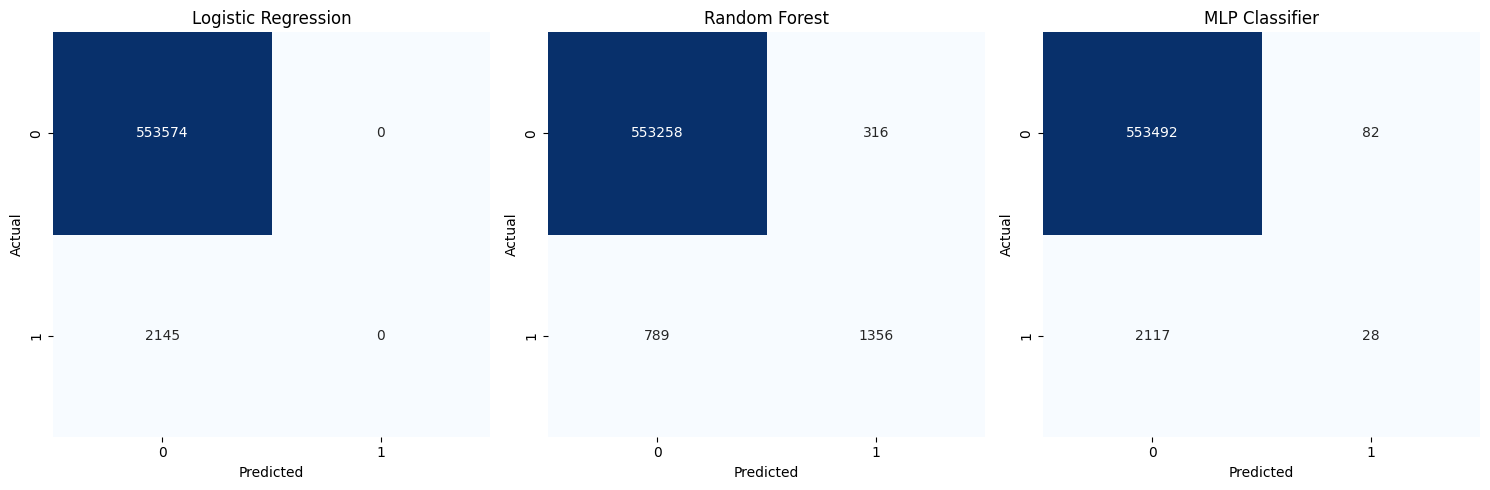

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic Regression
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# MLP Classifier
model_mlp = MLPClassifier(hidden_layer_sizes=(20,), max_iter=200, random_state=42)
model_mlp.fit(X_train, y_train)
y_pred_mlp = model_mlp.predict(X_test)
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)

# Plotting heatmaps
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Logistic Regression Heatmap
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Random Forest Heatmap
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# MLP Classifier Heatmap
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[2])
axes[2].set_title('MLP Classifier')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

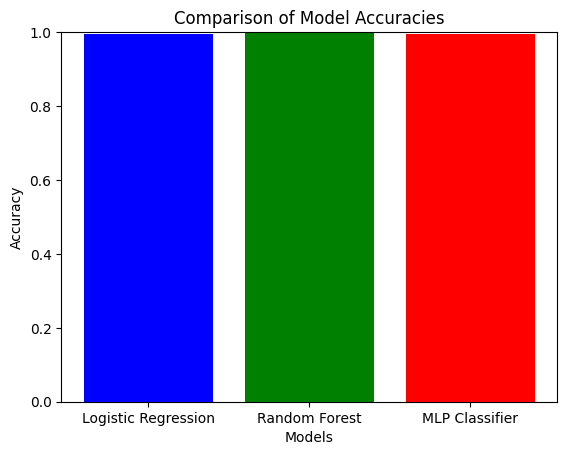

In [31]:
# Logistic Regression
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# MLP Classifier
model_mlp = MLPClassifier(hidden_layer_sizes=(20,), max_iter=200, random_state=42)
model_mlp.fit(X_train, y_train)
y_pred_mlp = model_mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

# Plotting accuracies
models = ['Logistic Regression', 'Random Forest', 'MLP Classifier']
accuracies = [accuracy_lr, accuracy_rf, accuracy_mlp]

plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)  # Set the y-axis limit to 0-1 for accuracy
plt.show()